In [75]:
# %load_ext jupyternotify
import numpy as np
import pandas as pd
import matplotlib
import math
from sklearn import model_selection, ensemble, metrics, linear_model, preprocessing, pipeline
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('dataset/undp_train.csv', na_values='nan')

In [3]:
test = pd.read_csv('dataset/undp_test.csv', na_values='nan')

In [81]:
list(enumerate(data.columns))

[(0, 'year'),
 (1, 'country'),
 (2, 'Life expectancy Index'),
 (3, 'Life expectancy at birth'),
 (4, 'Gross national income (GNI) per capita (2011 PPP$)'),
 (5, 'Income Index'),
 (6, 'Expected years of schooling (years)'),
 (7, 'Mean years of schooling (years)'),
 (8, 'Human Development Index (HDI)'),
 (9, 'Education Index'),
 (10, 'Population using at least basic drinking-water services (%)'),
 (11, 'Population using at least basic sanitation services (%)'),
 (12, 'Gross capital formation (% of GDP)'),
 (13, 'Population, total (millions)'),
 (14, 'Population, urban (%)'),
 (15, 'Mortality rate, under-five (per 1,000 live births)'),
 (16, 'Mortality rate, infant (per 1,000 live births)'),
 (17,
  'Old age dependency ratio (old age (65 and older) per 100 people (ages 15-64))'),
 (18, 'Population ages 15–64 (millions)'),
 (19, 'Population, ages 65 and older (millions)'),
 (20, 'Life expectancy at birth, male (years)'),
 (21, 'Life expectancy at birth, female (years)'),
 (22, 'Population,

In [84]:
index_columns = ['Life expectancy Index',
                 'Income Index',
                 'Human Development Index (HDI)',
                 'Human Development Index (HDI), female',
                 'Human Development Index (HDI), male',
                 'Education Index',
                 'Gender Development Index (GDI)',
                 'Gender Inequality Index (GII)', ]

In [5]:
data_no_world = data[data['country'] != 'World']

In [206]:
data_mod = data.loc[:, ['year', 'country'] + index_columns + ['y']]

In [210]:
data_mod = data_mod.set_index(['year', 'country'])

In [309]:
data_mod

,year,country,Life expectancy Index,Income Index,Human Development Index (HDI),"Human Development Index (HDI), female","Human Development Index (HDI), male",Education Index,Gender Development Index (GDI),Gender Inequality Index (GII),y
0,1990,Afghanistan,0.467,0.466,0.298,NaN,NaN,0.122,NaN,NaN,0.050220
1,1990,Albania,0.797,0.572,0.644,NaN,NaN,0.584,NaN,NaN,0.082286
2,1990,Algeria,0.722,0.695,0.578,NaN,NaN,0.385,NaN,NaN,0.064073
3,1990,Angola,0.389,0.562,NaN,NaN,NaN,NaN,NaN,NaN,0.049559
4,1990,Argentina,0.794,0.709,0.707,NaN,NaN,0.628,NaN,NaN,0.074967
...,...,...,...,...,...,...,...,...,...,...,...
3860,2015,United States,0.906,0.950,0.917,0.915,0.921,0.894,0.993,0.219,0.100069
3861,2015,Uzbekistan,0.784,0.612,0.696,0.672,0.715,0.704,0.940,0.303,0.037598
3862,2015,Venezuela (Bolivarian Republic of),0.809,0.758,0.763,0.769,0.753,0.724,1.021,0.470,0.046967
3863,2015,World,0.799,0.754,0.722,0.699,0.743,0.626,0.940,0.449,0.033304


In [269]:
data_mod = data_mod.reset_index()

In [213]:
idx = pd.IndexSlice

Text(0, 0.5, 'y')

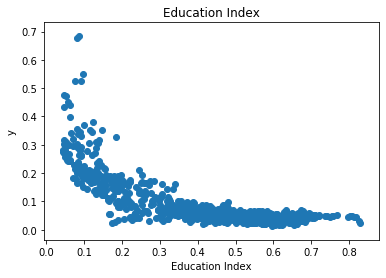

In [310]:
import math
i = 7
x = data_mod.set_index(['year', 'country']).loc[idx[:, :], index_columns[i]]
y = data_mod.set_index(['year', 'country']).loc[idx[:, :], 'y']

plt.scatter(x, y)
plt.title(data_mod.columns[i])
plt.xlabel(data_mod.columns[i])
plt.ylabel('y')

In [258]:
summ = data_mod.iloc[:, i].fillna(value=0) * 0
for i in range(6):
    summ += -1/(data_mod.iloc[:, i].fillna(value=0)-1.1)

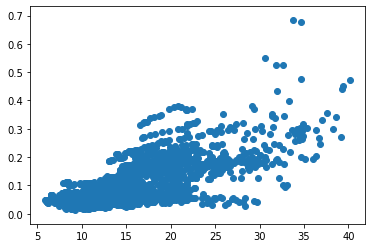

In [259]:
plt.scatter(summ, data_mod['y'])

Text(0, 0.5, 'y')

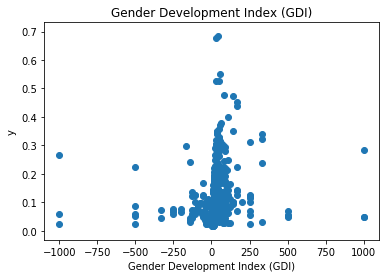

In [201]:
i = 6
plt.scatter(-1/(data_mod.iloc[:, i]-1), data_mod['y'])
plt.title(data_mod.columns[i])
plt.xlabel(data_mod.columns[i])
plt.ylabel('y')

In [345]:
data_mod = data_mod.set_index(['year', 'country'])

In [321]:
def transf1(x):
    return -1/(x-1.1)
def transf2(x):
    return 1/(x)

Text(0, 0.5, 'y')

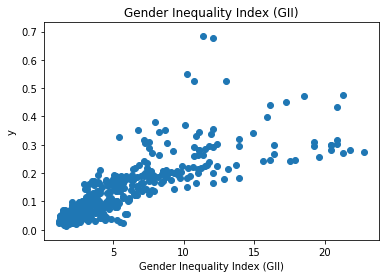

In [343]:
i = 9
plt.scatter(list(map(transf2, data_mod.iloc[:, i])), data_mod['y'])
plt.title(data_mod.columns[i])
plt.xlabel(data_mod.columns[i])
plt.ylabel('y')

In [349]:
data_mod_inv = data_mod[index_columns[:7]].apply(transf)

In [350]:
data_mod_inv[data_mod[index_columns[-1]].apply(transf2).name] = data_mod[index_columns[-1]].apply(transf2)

In [352]:
data_mod_inv['y'] = data.set_index(['year', 'country'])['y']

In [355]:
data_mod_inv = data_mod_inv.reset_index()

In [364]:
data_mod_inv_no_cat = data_mod_inv.drop(columns=['year', 'country'])

In [348]:
data_mod[index_columns[-1]].apply(transf2).name

'Gender Inequality Index (GII)'

In [365]:
data_mod_inv_no_cat

,Life expectancy Index,Income Index,Human Development Index (HDI),"Human Development Index (HDI), female","Human Development Index (HDI), male",Education Index,Gender Development Index (GDI),Gender Inequality Index (GII),y
0,1.579779,1.577287,1.246883,NaN,NaN,1.022495,NaN,NaN,0.050220
1,3.300330,1.893939,2.192982,NaN,NaN,1.937984,NaN,NaN,0.082286
2,2.645503,2.469136,1.915709,NaN,NaN,1.398601,NaN,NaN,0.064073
3,1.406470,1.858736,NaN,NaN,NaN,NaN,NaN,NaN,0.049559
4,3.267974,2.557545,2.544529,NaN,NaN,2.118644,NaN,NaN,0.074967
...,...,...,...,...,...,...,...,...,...
3860,5.154639,6.666667,5.464481,5.405405,5.586592,4.854369,9.345794,4.566210,0.100069
3861,3.164557,2.049180,2.475248,2.336449,2.597403,2.525253,6.250000,3.300330,0.037598
3862,3.436426,2.923977,2.967359,3.021148,2.881844,2.659574,12.658228,2.127660,0.046967
3863,3.322259,2.890173,2.645503,2.493766,2.801120,2.109705,6.250000,2.227171,0.033304


In [375]:
data_mod = data_mod.reset_index()

In [385]:
data_mod

,year,country,Life expectancy Index,Income Index,Human Development Index (HDI),"Human Development Index (HDI), female","Human Development Index (HDI), male",Education Index,Gender Development Index (GDI),Gender Inequality Index (GII),y
0,1990,Afghanistan,0.467,0.466,0.298,NaN,NaN,0.122,NaN,NaN,0.050220
1,1990,Albania,0.797,0.572,0.644,NaN,NaN,0.584,NaN,NaN,0.082286
2,1990,Algeria,0.722,0.695,0.578,NaN,NaN,0.385,NaN,NaN,0.064073
3,1990,Angola,0.389,0.562,NaN,NaN,NaN,NaN,NaN,NaN,0.049559
4,1990,Argentina,0.794,0.709,0.707,NaN,NaN,0.628,NaN,NaN,0.074967
...,...,...,...,...,...,...,...,...,...,...,...
3860,2015,United States,0.906,0.950,0.917,0.915,0.921,0.894,0.993,0.219,0.100069
3861,2015,Uzbekistan,0.784,0.612,0.696,0.672,0.715,0.704,0.940,0.303,0.037598
3862,2015,Venezuela (Bolivarian Republic of),0.809,0.758,0.763,0.769,0.753,0.724,1.021,0.470,0.046967
3863,2015,World,0.799,0.754,0.722,0.699,0.743,0.626,0.940,0.449,0.033304


In [424]:
data_mod

,year,country,Life expectancy Index,Income Index,Human Development Index (HDI),"Human Development Index (HDI), female","Human Development Index (HDI), male",Education Index,Gender Development Index (GDI),Gender Inequality Index (GII),y
0,1990,Afghanistan,0.467,0.466,0.298,NaN,NaN,0.122,NaN,NaN,0.050220
1,1990,Albania,0.797,0.572,0.644,NaN,NaN,0.584,NaN,NaN,0.082286
2,1990,Algeria,0.722,0.695,0.578,NaN,NaN,0.385,NaN,NaN,0.064073
3,1990,Angola,0.389,0.562,NaN,NaN,NaN,NaN,NaN,NaN,0.049559
4,1990,Argentina,0.794,0.709,0.707,NaN,NaN,0.628,NaN,NaN,0.074967
...,...,...,...,...,...,...,...,...,...,...,...
3860,2015,United States,0.906,0.950,0.917,0.915,0.921,0.894,0.993,0.219,0.100069
3861,2015,Uzbekistan,0.784,0.612,0.696,0.672,0.715,0.704,0.940,0.303,0.037598
3862,2015,Venezuela (Bolivarian Republic of),0.809,0.758,0.763,0.769,0.753,0.724,1.021,0.470,0.046967
3863,2015,World,0.799,0.754,0.722,0.699,0.743,0.626,0.940,0.449,0.033304


In [427]:
data_mod_no_year_country = data_mod.drop(columns=['year', 'country'])

In [445]:
data_no_cat = data.drop(columns=['year', 'country'])

In [454]:
data_mod_no_country = data_mod.drop(columns=['country'])

In [509]:
data.set_index()

,year,country,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,...,"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII),y
0,1990,Afghanistan,0.467,50.3,2193.0,0.466,2.6,1.5,0.298,0.122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050220
1,1990,Albania,0.797,71.8,4415.0,0.572,11.6,7.8,0.644,0.584,...,NaN,NaN,NaN,NaN,NaN,2.3,0.1,NaN,NaN,0.082286
2,1990,Algeria,0.722,66.9,9989.0,0.695,9.6,3.6,0.578,0.385,...,NaN,NaN,NaN,NaN,NaN,9.0,0.1,NaN,NaN,0.064073
3,1990,Angola,0.389,45.3,4139.0,0.562,3.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,0.049559
4,1990,Argentina,0.794,71.6,10932.0,0.709,13.2,7.9,0.707,0.628,...,NaN,NaN,NaN,NaN,NaN,6.6,0.1,-0.4,NaN,0.074967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860,2015,United States,0.906,78.9,54039.0,0.950,16.2,13.3,0.917,0.894,...,74.6,16.8,0.915,0.921,0.993,7.5,NaN,-1.4,0.219,0.100069
3861,2015,Uzbekistan,0.784,70.9,5759.0,0.612,11.7,11.4,0.696,0.704,...,42.8,6.1,0.672,0.715,0.940,NaN,0.2,NaN,0.303,0.037598
3862,2015,Venezuela (Bolivarian Republic of),0.809,72.6,15101.0,0.758,14.0,10.1,0.763,0.724,...,64.0,5.1,0.769,0.753,1.021,NaN,NaN,NaN,0.470,0.046967
3863,2015,World,0.799,72.0,14709.0,0.754,12.5,8.3,0.722,0.626,...,NaN,9.9,0.699,0.743,0.940,11.1,1.0,-0.2,0.449,0.033304


In [504]:
# Data manipulation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS

def RMSE(x,y):
    return MSE(x,y)**0.5

# numeric_data_indices = list(range(len(data.columns)-1))
# numeric_data_indices.remove(1)
# numeric_data_indices.remove(0)
numeric_data_indices = list(range(2,len(data.columns)-1))

#categorical_data_indices = [0, 1]
categorical_data_indices = [0, 1]


# Pipeline
pipe = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('imputing', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
        ]))
    ]
)

# shortcut for scorer
nrmse = 'neg_root_mean_squared_error'

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X = pipe.fit_transform(X)

# split
(X_train, X_test, y_train,
 y_test) = model_selection.train_test_split(X, y,
          test_size = 0.2, shuffle=False, random_state=425)

In [505]:
from sklearn.compose import TransformedTargetRegressor as TransTargReg
from sklearn.preprocessing import QuantileTransformer, quantile_transform


qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal' )

# lr = TransTargReg(regressor=linear_model.LinearRegression(),
#                   transformer=qt)
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

train_rmse = RMSE(y_train, lr.predict(X_train))
test_rmse = RMSE(y_test, lr.predict(X_test))
print(-CVS(lr, X_train, y_train, scoring=nrmse, cv=10).mean(), 'CV score Linreg on train data')
print(test_rmse, 'Linreg on test data\n')

# Ridgereg = TransTargReg(regressor=linear_model.Ridge(   
#     alpha=1.0,
#     fit_intercept=True,
#     normalize=False,
#     copy_X=True,
#     max_iter=None,
#     tol=0.0001,
#     solver='auto',
#     random_state=None,
# ),
#                       transformer=qt)
Ridgereg = linear_model.Ridge(
    alpha=0.001,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    max_iter=None,
    tol=0.0001,
    solver='auto',
    random_state=None,
)

Ridgereg.fit(X_train, y_train)

test_rmse = RMSE(y_test, Ridgereg.predict(X_test))
print(-CVS(Ridgereg, X_train, y_train, scoring=nrmse, cv=10).mean(), 'CV 10-fold score Ridgereg on train data')
print(test_rmse, 'Ridge on test data\n')

lasso = linear_model.Lasso(
    alpha=0.001,
    fit_intercept=True,
    normalize=False,
    precompute=False,
    copy_X=True,
    max_iter=1000,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)

lasso.fit(X_train, y_train)

test_rmse = RMSE(y_test, lasso.predict(X_test))
print(-CVS(lasso, X_train, y_train, scoring=nrmse, cv=10).mean(), 'CV 10-fold score LASSO on train data')
print(test_rmse, 'LASSO on test data')

0.006114119507891201 CV score Linreg on train data
0.037930771993139475 Linreg on test data

0.006443740458357097 CV 10-fold score Ridgereg on train data
0.03784472065918219 Ridge on test data

0.037303941570915815 CV 10-fold score LASSO on train data
0.061656849753591765 LASSO on test data


In [506]:
#XGBoost WITHOUT target transform
import xgboost as xgb
XGB = xgb.XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1500,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=3,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=0.3,
    reg_alpha=0,
    reg_lambda=0.001,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
    seed=None,
    missing=None,
    importance_type='gain')
XGB.fit(X_train, y_train)

print(MSE(y_train, XGB.predict(X_train))**0.5)
print(MSE(y_test, XGB.predict(X_test))**0.5)

0.0004958788599315283
0.038388330230424546


In [507]:
abs(XGB.predict(X_train) - y_train)

array([4.21394720e-05, 1.75195141e-04, 2.80547536e-04, ...,
       1.10473939e-04, 5.70348659e-04, 4.37454440e-04])

In [508]:
cvs = -CVS(XGB, X_train,y_train, scoring=nrmse, cv=5)
print(cvs.mean(), 'CV score 5-fold of XGB on train')

0.007715773410419071 CV score 5-fold of XGB on train


In [498]:
cvs

array([0.00900138, 0.00719585, 0.02018723, 0.00900573, 0.01097335])

In [78]:
#Let's use RandomForest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500,
                              criterion='mse',
                              max_depth=None,
                              min_samples_split=2,
                              min_samples_leaf=1,
#                              max_features=26,
                              max_features=86,
                              n_jobs=3)

print(-CVS(forest, X_train,y_train, scoring=nrmse, cv=5).mean(), 'CV score 5-fold of RandomForest on train')
forest.fit(X_train, y_train)
print(RMSE(y_test, forest.predict(X_test)))

0.014048396146600828 CV score 5-fold of RandomForest on train
0.008773215580983748


In [44]:
# Tuning hyperparameters of XGBoost
%%time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#GridSearchCV for XGBoost RF hyperparameters
param_grid = {
    'reg_lambda': [0.13, 0.12, 0.11, 0.1, 0.09, 0.08],
    'max_depth': [4, 5, 6],
    'colsample_bynode': [0.3, 0.6, 1]
}
XGB_GSCV = model_selection.GridSearchCV(XGB,
                                        param_grid=param_grid,
                                        n_jobs=None,
                                        scoring='neg_root_mean_squared_error',
                                        cv=5)
XGB_GSCV.fit(X_train, y_train)

CPU times: user 1h 45min 16s, sys: 18.6 s, total: 1h 45min 35s
Wall time: 35min 45s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1500, n_jobs=3, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=42, reg_alpha=0,
                                    reg_lambda=0.11, scale_pos_weight=1,
                                    seed=None, silent=None, subsample=0.7,
                                    verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bynode': [0.3, 0.6, 1],
                       

In [45]:
XGB_GSCV.best_params_

{'colsample_bynode': 0.6, 'max_depth': 4, 'reg_lambda': 0.08}

In [48]:
XGB_GSCV.best_score_

-0.0083316207936785

In [54]:
param_grid

{'reg_lambda': [0.13, 0.12, 0.11, 0.1, 0.09, 0.08],
 'max_depth': [4, 5, 6],
 'colsample_bynode': [0.3, 0.6, 1]}

In [56]:
XGB_GSCV.cv_results_

{'mean_fit_time': array([ 5.35350151,  4.87943206,  4.85555339,  4.87456136,  4.80746737,
         4.80907297,  5.09512296,  5.09345832,  5.10580516,  5.15837402,
         5.06124406,  5.09585752,  4.95092335,  4.98737736,  5.10969477,
         4.94382687,  4.95660944,  4.95098252,  7.52046118,  7.5075017 ,
         7.51507001,  7.49919958,  7.47103252,  7.50139384,  7.91650324,
         7.91747699,  7.88186531,  7.80968275,  7.85383649,  7.90951095,
         7.59507589,  7.61667442,  7.5712791 ,  7.56280618,  7.59449124,
         7.56464252, 10.62132335, 10.71043348, 10.72371988, 10.6653779 ,
        10.66552935, 10.70967669, 11.21602669, 11.27209802, 11.17600584,
        11.23389516, 11.23780007, 11.2046876 , 10.74959779, 10.6928494 ,
        10.80183973, 10.77556095, 10.69891982, 10.74421024]),
 'std_fit_time': array([0.47435578, 0.11116361, 0.10298132, 0.02329494, 0.09963057,
        0.04510971, 0.06636834, 0.06168506, 0.06890871, 0.07231984,
        0.06194179, 0.05726436, 0.10532

In [62]:
sorted(list(zip(XGB_GSCV.cv_results_['mean_test_score'], XGB_GSCV.cv_results_['params'])))

[(-0.009779392293374113,
  {'colsample_bynode': 1, 'max_depth': 6, 'reg_lambda': 0.08}),
 (-0.009726701717089942,
  {'colsample_bynode': 1, 'max_depth': 6, 'reg_lambda': 0.1}),
 (-0.009689492992774126,
  {'colsample_bynode': 0.6, 'max_depth': 6, 'reg_lambda': 0.1}),
 (-0.009667603767947343,
  {'colsample_bynode': 1, 'max_depth': 6, 'reg_lambda': 0.09}),
 (-0.009610254999647414,
  {'colsample_bynode': 1, 'max_depth': 6, 'reg_lambda': 0.13}),
 (-0.009604993594268883,
  {'colsample_bynode': 1, 'max_depth': 6, 'reg_lambda': 0.11}),
 (-0.009514918851870155,
  {'colsample_bynode': 0.6, 'max_depth': 6, 'reg_lambda': 0.08}),
 (-0.009513235715750124,
  {'colsample_bynode': 1, 'max_depth': 6, 'reg_lambda': 0.12}),
 (-0.009481743459453237,
  {'colsample_bynode': 0.6, 'max_depth': 6, 'reg_lambda': 0.09}),
 (-0.009469051217315528,
  {'colsample_bynode': 0.6, 'max_depth': 6, 'reg_lambda': 0.11}),
 (-0.009455014586638496,
  {'colsample_bynode': 0.3, 'max_depth': 6, 'reg_lambda': 0.13}),
 (-0.00938754

In [50]:
print(RMSE(y_test, XGB_GSCV.best_estimator_.predict(X_test)))

0.008482756118082567
